GAN code from [this link](https://github.com/wiseodd/generative-models/blob/master/GAN/vanilla_gan/gan_pytorch.py)

In [1]:
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [241]:
z_dim = 25
h1_dim = 40
h2_dim = 64
x_dim = 784

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.elu = nn.ELU()
        self.fc3 = nn.Linear(h1_dim, x_dim)
        
    def forward(self, x):
        out = self.elu(self.fc1(x))
        #out = self.elu(self.fc2(out))
        out = self.fc3(out)
        return out

In [242]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h1_dim)
        self.fc2 = nn.Linear(h1_dim, 1)
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.elu(self.fc1(x))
        out = self.fc2(out)
        return out

In [243]:
generator = Generator()
discriminator = Discriminator()

## Prepare data

In [244]:
train_data = dsets.MNIST(root="./datasets/",
                  train=True, transform=transforms.ToTensor())

In [245]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

In [246]:
(img, label_) = iter(train_loader).next()

print(img.size())

img_ = img.view(batch_size, -1)
print(img_.size())

torch.Size([256, 1, 28, 28])
torch.Size([256, 784])


In [247]:
img1 = Variable(img_)
blah = discriminator(img1)

blah.size()

torch.Size([256, 1])

In [248]:
ones_label = Variable(torch.ones(batch_size)).unsqueeze(1)
zeros_label = Variable(torch.zeros(batch_size)).unsqueeze(1)

In [249]:
ones_label.size()

torch.Size([256, 1])

In [250]:
bl_loss = criterion(blah, ones_label)

In [251]:
bl_loss.data[0]

1.0923508405685425

In [252]:
lr = 0.001
D_solver = torch.optim.Adam(discriminator.parameters(), lr=lr)
G_solver = torch.optim.Adam(generator.parameters(), lr=lr)

In [253]:
criterion = nn.MSELoss()

In [254]:
import time
import math

In [255]:
def timesince(since):
    end = time.time() - since
    m = math.floor(end / 60)
    end -= m*60
    return (m, end)

Iter-0, D_loss:1.103014, G_loss:0.987294
Iter-50, D_loss:0.276072, G_loss:0.263318
Iter-100, D_loss:0.266602, G_loss:0.266030
Iter-150, D_loss:0.249903, G_loss:0.252744
Iter-200, D_loss:0.264301, G_loss:0.249284
Epoch: 0 time: 0m 4s
Iter-0, D_loss:0.257214, G_loss:0.253959
Iter-50, D_loss:0.259650, G_loss:0.247150
Iter-100, D_loss:0.254017, G_loss:0.260085
Iter-150, D_loss:0.257353, G_loss:0.256484
Iter-200, D_loss:0.255268, G_loss:0.254898
Epoch: 1 time: 0m 4s
Iter-0, D_loss:0.256777, G_loss:0.255670
Iter-50, D_loss:0.251761, G_loss:0.260571
Iter-100, D_loss:0.249182, G_loss:0.250946
Iter-150, D_loss:0.259399, G_loss:0.249960
Iter-200, D_loss:0.251270, G_loss:0.248253
Epoch: 2 time: 0m 4s
Iter-0, D_loss:0.252909, G_loss:0.250442
Iter-50, D_loss:0.251140, G_loss:0.250667
Iter-100, D_loss:0.251726, G_loss:0.251863
Iter-150, D_loss:0.254784, G_loss:0.251526
Iter-200, D_loss:0.250787, G_loss:0.251186
Epoch: 3 time: 0m 4s
Iter-0, D_loss:0.253488, G_loss:0.245920
Iter-50, D_loss:0.250162, G

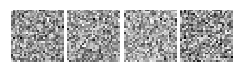

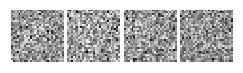

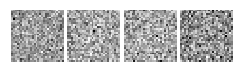

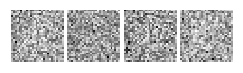

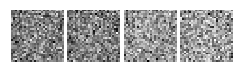

In [256]:
epochs = 5

for epoch in range(epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_loader):
        # sample data
        z = Variable(torch.randn(batch_size, z_dim))
        
        # X size is <batch_size, x_dim>
        X = Variable(images.view(batch_size, -1))
        #print(X.size())
                     
        # Discriminator update
        G_sample = generator(z)
        D_real = discriminator(X)
        D_fake = discriminator(G_sample)
        
        D_real_loss = criterion(D_real, ones_label)
        D_fake_loss = criterion(D_fake, zeros_label)
        
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        
        D_solver.step()
        D_solver.zero_grad() # reset the gradients
        
        # Generator update
        z = Variable(torch.randn(batch_size, z_dim))
        G_sample = generator(z)
        D_fake = discriminator(G_sample)
        
        G_loss = criterion(D_fake, ones_label)
        
        G_loss.backward()
        G_solver.step()
        G_solver.zero_grad()
        
        if i % 50 == 0:
            print("Iter-%d, D_loss:%f, G_loss:%f" %(i,
                                                   D_loss.data.numpy(),
                                                   G_loss.data.numpy()))
    (m, s) = timesince(start)
    
    z = Variable(torch.randn(batch_size, z_dim))
    samples = generator(z).data.numpy()[:4]
    
    fig = plt.figure(figsize=(4,4))
    gs = gridspec.GridSpec(4,4)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(sample.reshape(28, 28), cmap="Greys_r")
        
    print("Epoch: %d time: %dm %ds" %(epoch, m, s))